In [5]:
import sys
import os



import numpy as np
from SynthTempNetwork import Individual, SynthTempNetwork
from TemporalNetwork import ContTempNetwork, StaticTempNetwork
from FlowStability import FlowIntegralClustering
import pickle

import matplotlib.pyplot as plt
import matplotlib

from scipy.sparse import (lil_matrix, dok_matrix, diags, eye, isspmatrix_csr, isspmatrix,
                          csr_matrix, coo_matrix, csc_matrix)
from scipy.sparse.linalg import eigsh

In [6]:
lamdas=np.logspace(-4,2,20)
print(lamdas)
between_lamdas=np.linspace(-4,2,20)

[1.00000000e-04 2.06913808e-04 4.28133240e-04 8.85866790e-04
 1.83298071e-03 3.79269019e-03 7.84759970e-03 1.62377674e-02
 3.35981829e-02 6.95192796e-02 1.43844989e-01 2.97635144e-01
 6.15848211e-01 1.27427499e+00 2.63665090e+00 5.45559478e+00
 1.12883789e+01 2.33572147e+01 4.83293024e+01 1.00000000e+02]


In [7]:
net = ContTempNetwork.load('fig3_network_short')

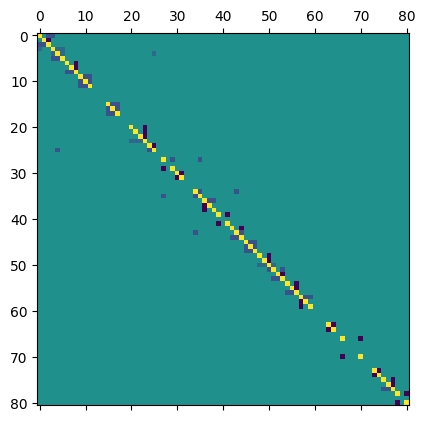

In [8]:
plt.matshow(net.laplacians[100].toarray())

In [9]:
list_forw_flows = []

for i in lamdas:
    list_forw_flows.append(FlowIntegralClustering(T_inter_list=net.inter_T[i],
                                  time_list=net.times,
                                  verbose=True))

PID  20264  : computing T_list
PID  20264  : computing integral
PID  20264  :  0  over  459  took 0.00s
integral took 0.14s
PID  20264  : computing T_list
PID  20264  : computing integral
PID  20264  :  0  over  459  took 0.00s
integral took 0.13s
PID  20264  : computing T_list
PID  20264  : computing integral
PID  20264  :  0  over  459  took 0.00s
integral took 0.13s
PID  20264  : computing T_list
PID  20264  : computing integral
PID  20264  :  0  over  459  took 0.00s
integral took 0.13s
PID  20264  : computing T_list
PID  20264  : computing integral
PID  20264  :  0  over  459  took 0.00s
integral took 0.13s
PID  20264  : computing T_list
PID  20264  : computing integral
PID  20264  :  0  over  459  took 0.00s
integral took 0.12s
PID  20264  : computing T_list
PID  20264  : computing integral
PID  20264  :  0  over  459  took 0.00s
integral took 0.13s
PID  20264  : computing T_list
PID  20264  : computing integral
PID  20264  :  0  over  459  took 0.00s
integral took 0.12s
PID  202

In [10]:
for i in range(len(lamdas)):
    list_forw_flows[i].find_louvain_clustering()

In [47]:
list_forw_flows[18].clustering[0]

TypeError: 'SparseClustering' object is not subscriptable

### Generating/Saving/Loading static networks

In [11]:
# #Generating Networks

# static_net_adj = net.compute_static_adjacency_matrix()

# #weighted
# #Combinatorial Laplacian
# static_net_weighted_heat = StaticTempNetwork(times = net.times, adjacency = static_net_adj)
# static_net_weighted_heat.compute_laplacian_matrices(random_walk = False)
# for i in lamdas:
#     static_net_weighted_heat.compute_inter_transition_matrices(lamda=i, dense_expm=False, use_sparse_stoch=False)
#     static_net_weighted_heat.compute_transition_matrices(lamda=i)

# #Random Walk Laplacian
# static_net_weighted = StaticTempNetwork(times = net.times, adjacency = static_net_adj)
# static_net_weighted.compute_laplacian_matrices(random_walk = True)
# for i in lamdas:
#     static_net_weighted.compute_inter_transition_matrices(lamda=i, dense_expm=False, use_sparse_stoch=False)
#     static_net_weighted.compute_transition_matrices(lamda=i)


# #unweighted
# #entries are sum of durations of events, need to set to 1
# static_net_adj = static_net_adj.toarray()
# static_net_adj[static_net_adj != 0] = 1
# static_net_adj = csr_matrix(static_net_adj)

# #Combinatorial Laplacian
# static_net_heat = StaticTempNetwork(times = net.times, adjacency = static_net_adj)
# static_net_heat.compute_laplacian_matrices(random_walk = False)
# for i in lamdas:
#     static_net_heat.compute_inter_transition_matrices(lamda=i, dense_expm=False, use_sparse_stoch=False)
#     static_net_heat.compute_transition_matrices(lamda=i)

# #Random Walk Laplacian
# static_net = StaticTempNetwork(times = net.times, adjacency = static_net_adj)
# static_net.compute_laplacian_matrices(random_walk = True)
# for i in lamdas:
#     static_net.compute_inter_transition_matrices(lamda=i, dense_expm=False, use_sparse_stoch=False)
#     static_net.compute_transition_matrices(lamda=i)

In [12]:
# #Saving Networks
# static_net_weighted_heat.save('fig3_network_static_weighted_heat')
# static_net_weighted.save('fig3_network_static_weighted')
# static_net_heat.save('fig3_network_static_heat')
# static_net.save('fig3_network_static')

In [13]:
#Loading Networks
static_net_weighted_heat = StaticTempNetwork.load('fig3_network_static_weighted_heat')
static_net_weighted = StaticTempNetwork.load('fig3_network_static_weighted')
static_net_heat = StaticTempNetwork.load('fig3_network_static_heat')
static_net = StaticTempNetwork.load('fig3_network_static')

In [14]:
def one_time(s):
    one_time_s = []
    for key in s.keys():
        for i in s[key]:
            one_time_s.append(i)
    return one_time_s

def derivative(v1, v2):
    assert len(v1) == len(v2), "Error: in order to compute the numerical derivative, the two varibales need to have the same lenght."
    derivative = []
    for i, vi in enumerate(v1[1:]):
        m1 =(vi - v1[i-1])/(v2[i]-v2[i-1])
        m2 =(v1[i+1] - vi)/(v2[i+1]-v2[i])
        derivative.append((m1+m2)/2)
    return derivative

# Unweighted Static Network

### Spectral vNS

In [15]:
for i in lamdas:
    static_net_heat.compute_spectral_vonNeumann_entropy(lamda=i, force_csr=True, time_domain = static_net_heat.times[-1:])

Text(0.5, 1.0, 'Spectral vNS')

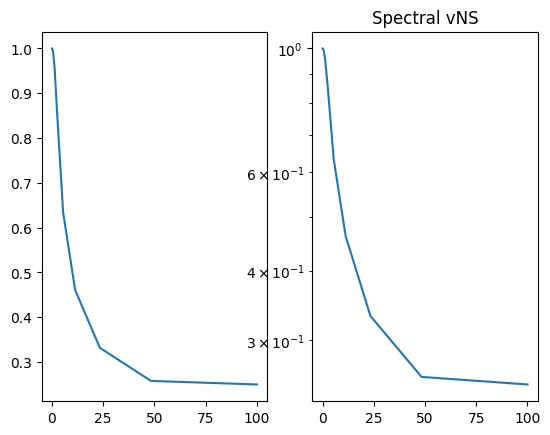

In [16]:
plt.subplot(1, 2, 1)
plt.plot(lamdas, one_time(static_net_heat.spectral_vNS))

plt.subplot(1, 2, 2)
plt.plot(lamdas, one_time(static_net_heat.spectral_vNS))
plt.yscale('log')
plt.title('Spectral vNS')

### Von Neumann Entropy

In [17]:
for i in lamdas:
    static_net_heat.compute_vonNeumann_entropy(lamda=i, force_csr=True, time_domain = static_net_heat.times[-1:])

/Users/samuelkoovely/Documents/GitHub/flow_stability/flow_stability_env/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'vNS')

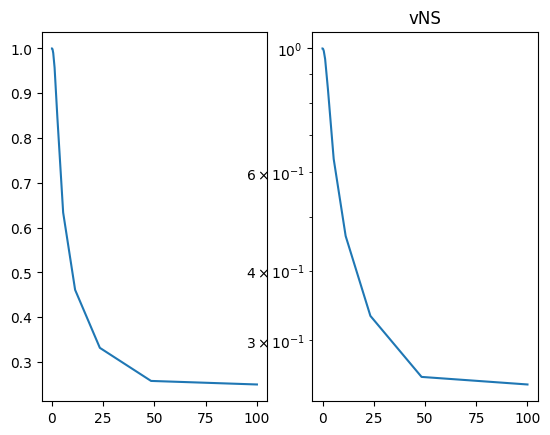

In [18]:
plt.subplot(1, 2, 1)
plt.plot(lamdas, one_time(static_net_heat.vNS))

plt.subplot(1, 2, 2)
plt.plot(lamdas, one_time(static_net_heat.vNS))
plt.yscale('log')
plt.title('vNS')

In [19]:
#comparison between the two

print(one_time(static_net_heat.vNS))
print(one_time(static_net_heat.spectral_vNS))

[0.9999999997368922, 0.9999999988735423, 0.9999999951771966, 0.9999999793514173, 0.9999999115916176, 0.9999996214507123, 0.9999983789200283, 0.9999930562422337, 0.9999702421484918, 0.9998723478898576, 0.999451476706013, 0.9976376828838888, 0.9898366398643003, 0.9574343576132825, 0.8459120524228092, 0.6338703870300532, 0.4613409121889691, (0.3318440094492328+2.825314422104714e-18j), (0.257981224920226+7.14760913384049e-18j), (0.2500531567717279+5.597912578892772e-17j)]
[0.9999999997368925, 0.9999999988735421, 0.9999999951771964, 0.9999999793514168, 0.9999999115916175, 0.9999996214507119, 0.9999983789200276, 0.9999930562422334, 0.9999702421484913, 0.9998723478898573, 0.999451476706013, 0.9976376828838888, 0.9898366398643, 0.9574343576132813, 0.845912052422809, 0.6338703870300532, 0.46134091218896894, 0.33184400944923426, 0.2579812249202311, 0.2500531567717366]


## Derivatives

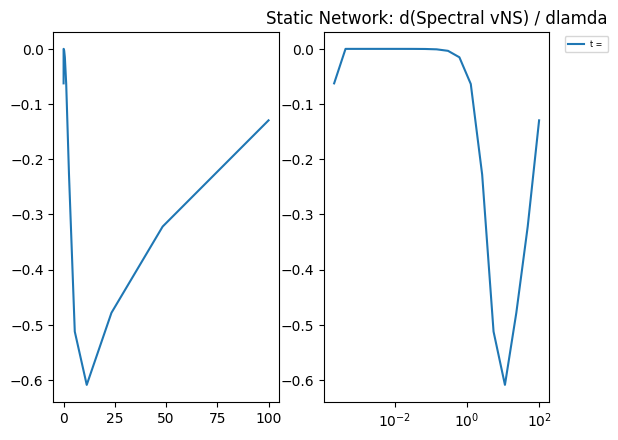

In [20]:
St = []
for j, lamda in enumerate(lamdas):
    St = one_time(static_net_heat.vNS)

v1 = St
v2 = between_lamdas
ds_dt = derivative(v1, v2)

plt.subplot(1, 2, 1)
plt.plot(lamdas[1:], ds_dt, label='t = ')

plt.subplot(1, 2, 2)
plt.plot(lamdas[1:], ds_dt, label='t = ')
plt.xscale('log')

plt.legend(fontsize='xx-small', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title('Static Network: d(Spectral vNS) / dlamda')
#plt.savefig('./figures/fig3_recap_entropy_plots/fig3_dspectral_vNS_dlamda.eps', format='eps')

plt.show()

# Weighted Static network

In [21]:
for i in lamdas:
    static_net_weighted_heat.compute_spectral_vonNeumann_entropy(lamda=i, force_csr=True, time_domain = static_net_heat.times[-1:])

In [22]:
for i in lamdas:
    static_net_weighted_heat.compute_vonNeumann_entropy(lamda=i, force_csr=True, time_domain = static_net_heat.times[-1:])

In [23]:
#comparison between the two

print(one_time(static_net_weighted_heat.vNS))
print(one_time(static_net_weighted_heat.spectral_vNS))

[0.9999997983187437, 0.9999991365603074, 0.9999963035598365, 0.9999841765953154, 0.9999322791591415, 0.9997103575745786, 0.9987639481958759, 0.9947690907735613, 0.9785827044928791, 0.9225441173521446, 0.8013923347649674, 0.6756157122498881, 0.5632922084540709, (0.45286761947682347+4.577144372615024e-18j), (0.34166183600538486+1.8739451007356977e-17j), (0.2642732079580361+6.843335137872794e-17j), (0.2502617468717544+2.0878500043963855e-17j), (0.2500000503062627+9.336591859137524e-17j), (0.2500000000000046+4.2496822299681826e-17j), (0.24999999999999964+3.660973074939457e-17j)]
[0.999999798318743, 0.9999991365603069, 0.9999963035598357, 0.9999841765953151, 0.9999322791591404, 0.999710357574578, 0.9987639481958751, 0.994769090773561, 0.9785827044928785, 0.9225441173521444, 0.8013923347649675, 0.6756157122498878, 0.5632922084540705, 0.45286761947682425, 0.341661836005391, 0.2642732079580426, 0.2502617468717603, 0.2500000503062692, 0.25000000000000844, 0.2500000000000076]


Text(0.5, 1.0, 'vNS')

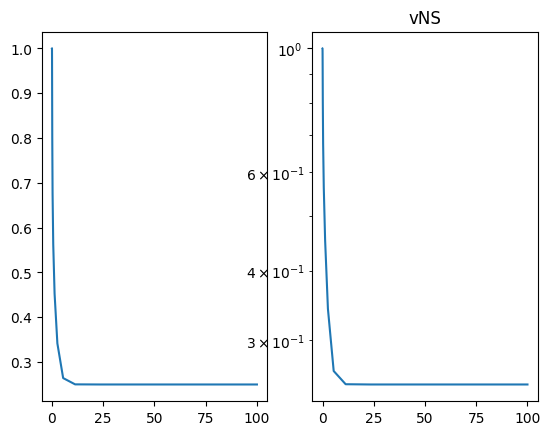

In [24]:
plt.subplot(1, 2, 1)
plt.plot(lamdas, one_time(static_net_weighted_heat.vNS))

plt.subplot(1, 2, 2)
plt.plot(lamdas, one_time(static_net_weighted_heat.vNS))
plt.yscale('log')
plt.title('vNS')

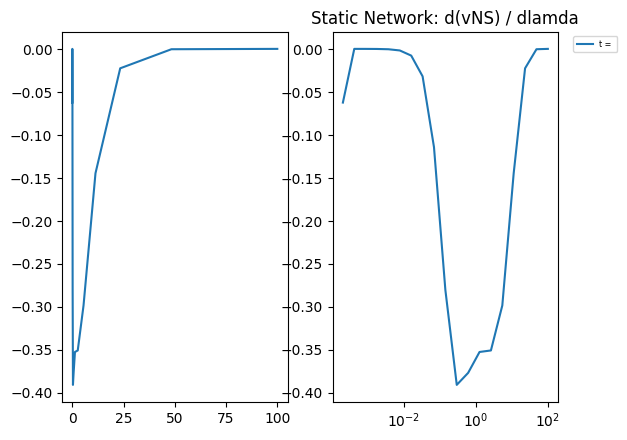

In [25]:
for j, lamda in enumerate(lamdas):
    St = one_time(static_net_weighted_heat.vNS)

    v1 = St
    v2 = between_lamdas
    ds_dt = derivative(v1, v2)

plt.subplot(1, 2, 1)
plt.plot(lamdas[1:], ds_dt, label='t = ')

plt.subplot(1, 2, 2)
plt.plot(lamdas[1:], ds_dt, label='t = ')
plt.xscale('log')

plt.legend(fontsize='xx-small', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title('Static Network: d(vNS) / dlamda')
#plt.savefig('./figures/fig3_recap_entropy_plots/fig3_dvNS_dlamda.eps', format='eps')

plt.show()

# Static Network Random Walk 

In [26]:
for i in lamdas:
    static_net.compute_vonNeumann_entropy(lamda=i, force_csr=True, time_domain = static_net_heat.times[-1:])

Text(0.5, 1.0, 'vNS')

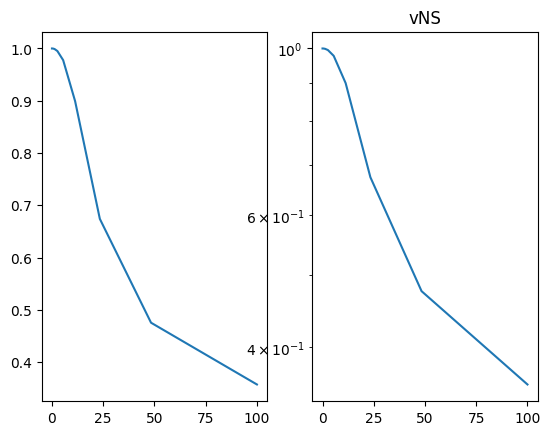

In [27]:
plt.subplot(1, 2, 1)
plt.plot(lamdas, one_time(static_net.vNS))

plt.subplot(1, 2, 2)
plt.plot(lamdas, one_time(static_net.vNS))
plt.yscale('log')
plt.title('vNS')

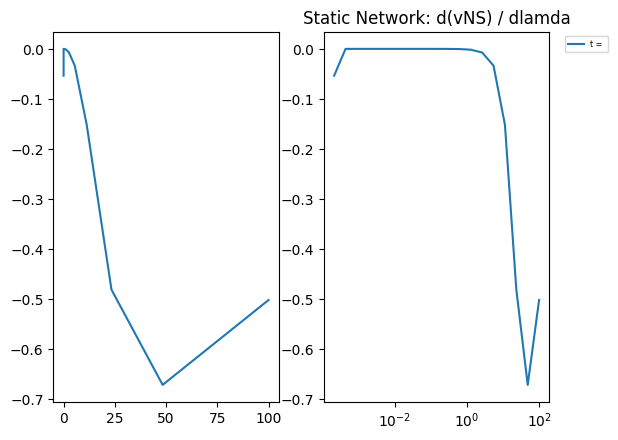

In [28]:
St = []
for j, lamda in enumerate(lamdas):
    St = one_time(static_net.vNS)

v1 = St
v2 = between_lamdas
ds_dt = derivative(v1, v2)

plt.subplot(1, 2, 1)
plt.plot(lamdas[1:], ds_dt, label='t = ')

plt.subplot(1, 2, 2)
plt.plot(lamdas[1:], ds_dt, label='t = ')
plt.xscale('log')

plt.legend(fontsize='xx-small', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title('Static Network: d(vNS) / dlamda')
#plt.savefig('./figures/fig3_recap_entropy_plots/fig3_dspectral_vNS_dlamda.eps', format='eps')

plt.show()

# Weighted Static Network Random Walk

In [29]:
for i in lamdas:
    static_net_weighted.compute_vonNeumann_entropy(lamda=i, force_csr=True, time_domain = static_net_heat.times[-1:])

Text(0.5, 1.0, 'vNS')

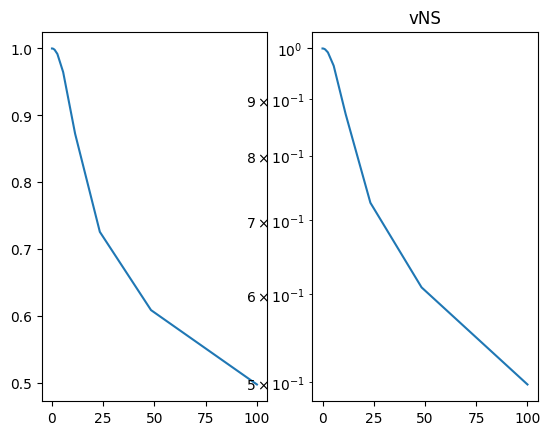

In [30]:
plt.subplot(1, 2, 1)
plt.plot(lamdas, one_time(static_net_weighted.vNS))

plt.subplot(1, 2, 2)
plt.plot(lamdas, one_time(static_net_weighted.vNS))
plt.yscale('log')
plt.title('vNS')

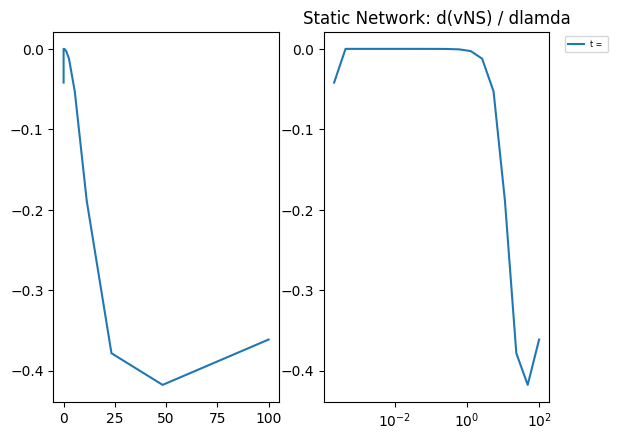

In [31]:
St = []
for j, lamda in enumerate(lamdas):
    St = one_time(static_net_weighted.vNS)

v1 = St
v2 = between_lamdas
ds_dt = derivative(v1, v2)

plt.subplot(1, 2, 1)
plt.plot(lamdas[1:], ds_dt, label='t = ')

plt.subplot(1, 2, 2)
plt.plot(lamdas[1:], ds_dt, label='t = ')
plt.xscale('log')

plt.legend(fontsize='xx-small', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title('Static Network: d(vNS) / dlamda')
#plt.savefig('./figures/fig3_recap_entropy_plots/fig3_dspectral_vNS_dlamda.eps', format='eps')

plt.show()

In [73]:
with open('test_lamda100.000000', 'rb') as f:
    pickle_test = pickle.load(f)

In [74]:
pickle_test.keys()

dict_keys(['lamda', 'inter_T', 'T', 'vNS'])

In [75]:
len(pickle_test['vNS'])

1

In [76]:
pickle_test['vNS']

[(0.24999999999999964+3.660973074939457e-17j)]

In [67]:
tuple([round(lamda, 6) for lamda in lamdas ])

(0.0001,
 0.000207,
 0.000428,
 0.000886,
 0.001833,
 0.003793,
 0.007848,
 0.016238,
 0.033598,
 0.069519,
 0.143845,
 0.297635,
 0.615848,
 1.274275,
 2.636651,
 5.455595,
 11.288379,
 23.357215,
 48.329302,
 100.0)

In [70]:
file='fig3_lamdas'
lamdasf6= [round(lamda, 6) for lamda in lamdas ]
with open(file, "w") as output:
    output.write('(')
    for lamda in lamdasf6[:-1]:
        output.write(str(lamda) + ' ' )
    output.write(str(lamdasf6[-1]) + ')')